In [1]:
import jax.numpy as jnp
import jax
import os
jax.config.update('jax_enable_x64',True)

from jsindy.trajectory_model import DataAdaptedRKHSInterpolant
from jsindy.sindy_model import JSINDyModel
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import LMSolver, AlternatingActiveSetLMSolver
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings


from equinox import tree_pprint
import matplotlib.pyplot as plt

from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp

import time
from equinox import tree_pprint
from jsindy.kernels import softplus_inverse

import jax
from jsindy.optim.solvers.lm_solver import CholeskyLM, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import AlternatingActiveSolve
from jsindy.trajectory_model import TrajectoryModel
from jax.scipy.linalg import block_diag
import jax.numpy as jnp
from jsindy.util import full_data_initialize
from dataclasses import dataclass
from jsindy.optim.optimizers import LMProblem,AASLMProblem



In [25]:
class TestSolver():
    def __init__(
            self, 
            beta_reg_vals = [1.,0.1,0.001],
            solver_settings =  LMSettings()
        ):
        self.solver_settings = solver_settings
        self.beta_reg_vals = beta_reg_vals

    def run(self, model, params):
        params["data_weight"] = 1/(params["sigma2_est"]+0.01)
        params["colloc_weight"] = 100.
        print(params)

        z0,theta0 = full_data_initialize(
            model.t,
            model.x,
            model.traj_model,
            model.dynamics_model,
            sigma2_est=params["sigma2_est"]+0.01
            )
        z_theta_init = jnp.hstack([z0,theta0.flatten()])

        def resid_func(z_theta):
            z = z_theta[:model.traj_model.tot_params]
            theta = z_theta[model.traj_model.tot_params:].reshape(
                model.dynamics_model.param_shape
            )
            return model.residuals.residual(
                z,
                theta,
                params["data_weight"], 
                params["colloc_weight"]
            )   

        jac_func = jax.jacrev(resid_func)
        damping_matrix = block_diag(
            model.traj_model.regmat,
            model.dynamics_model.regmat
        )

        lm_prob = LMProblem(resid_func, jac_func, damping_matrix)
        if self.solver_settings.show_progress:
            print("Warm Start")
        for beta in self.beta_reg_vals:
            z_theta, lm_opt_results = CholeskyLM(
                z_theta_init, 
                lm_prob,
                beta,
                self.solver_settings
            )
            z_theta_init= z_theta
        z = z_theta[:model.traj_model.tot_params]
        theta = z_theta[model.traj_model.tot_params:].reshape(
            model.dynamics_model.param_shape
        )

        if self.solver_settings.show_progress:
            print("Model after smooth warm start")
            model.print(theta = theta)
            print("Alternating Activeset Sparsifier")

        def F_split(z, theta):
            data_weight = params["data_weight"]
            colloc_weight = params["colloc_weight"]
            return model.residuals.residual(z,theta,data_weight,colloc_weight)

        # fix this later
        aaslm_prob = AASLMProblem(
            system_dim = model.traj_model.system_dim,
            num_features = model.dynamics_model.num_features,
            F_split = F_split,
            t_colloc = model.t_colloc,
            interpolant=model.traj_model,
            state_param_regmat=model.traj_model.regmat, 
            model_param_regmat=model.dynamics_model.regmat,
            feature_library=model.dynamics_model.feature_map
        )
        
        z, theta, aas_lm_opt_results = AlternatingActiveSolve(
            z0=z,
            theta0=theta,
            residual_objective=aaslm_prob,
            beta=self.beta_reg_vals[-1],
            show_progress=self.solver_settings.show_progress
        )
        theta = theta.reshape(
            model.dynamics_model.param_shape
        )

        return z, theta, [lm_opt_results,aas_lm_opt_results,], params


In [26]:
noise_var = 16.
dt = 0.08

exp_data = LorenzExp

In [27]:
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 600
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

trajectory_model = DataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 0.01)
optsettings = LMSettings(
    max_iter = 2000,
    min_alpha = 1e-15,
    max_alpha = 1e8,
    init_alpha=100.,
)
optimizer = TestSolver(beta_reg_vals = [1.,0.1,0.001],solver_settings=optsettings)

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)


In [28]:
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(10.65914167, dtype=float64), 'data_weight': Array(0.09372825, dtype=float64), 'colloc_weight': 100.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 3.061e+09, gradnorm = 9.893e+11, alpha = 100.0, improvement_ratio = 0.7378
Iteration 1, loss = 6.435e+08, gradnorm = 3.869e+12, alpha = 100.0, improvement_ratio = 0.7898
Line Search Failed!
Final Iteration Results
Iteration 2, loss = 9.397e+08, gradnorm = 3.869e+12, alpha = 3.99e+05, improvement_ratio = -0.4604


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 7.354e+07, gradnorm = 1.576e+12, alpha = 83.33, improvement_ratio = 0.9217
Iteration 1, loss = 5.7e+06, gradnorm = 1.044e+12, alpha = 69.44, improvement_ratio = 0.9225
Iteration 2, loss = 8.051e+05, gradnorm = 3.584e+11, alpha = 57.87, improvement_ratio = 0.8588
Iteration 3, loss = 3.406e+05, gradnorm = 6.218e+10, alpha = 57.87, improvement_ratio = 0.577
Iteration 4, loss = 1.31e+05, gradnorm = 4.874e+10, alpha = 57.87, improvement_ratio = 0.6154
Iteration 5, loss = 4.707e+04, gradnorm = 4.149e+10, alpha = 57.87, improvement_ratio = 0.641
Iteration 200, loss = 34.89, gradnorm = 4.822e+06, alpha = 430.0, improvement_ratio = 0.7182
Iteration 400, loss = 33.74, gradnorm = 6.546e+06, alpha = 298.6, improvement_ratio = 0.7217
Iteration 600, loss = 33.22, gradnorm = 5.209e+06, alpha = 298.6, improvement_ratio = 0.687
Iteration 800, loss = 32.91, gradnorm = 3.459e+06, alpha = 298.6, improvement_ratio = 0.722
Iteration 1000, loss = 32.66, gradnorm = 2.234e+06, alpha = 298.6

  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 23.95, gradnorm = 8.724e+05, alpha = 225.0, improvement_ratio = 0.5906
Iteration 1, loss = 23.94, gradnorm = 4.779e+06, alpha = 225.0, improvement_ratio = 0.7921
Iteration 2, loss = 23.93, gradnorm = 3.283e+06, alpha = 187.5, improvement_ratio = 0.8075
Iteration 3, loss = 23.93, gradnorm = 2.981e+06, alpha = 187.5, improvement_ratio = 0.6574
Iteration 4, loss = 23.92, gradnorm = 4.894e+06, alpha = 187.5, improvement_ratio = 0.697
Iteration 5, loss = 23.91, gradnorm = 5.684e+06, alpha = 187.5, improvement_ratio = 0.6818
Iteration 200, loss = 22.98, gradnorm = 3.599e+06, alpha = 75.35, improvement_ratio = 0.7818
Iteration 400, loss = 22.4, gradnorm = 1.468e+06, alpha = 36.34, improvement_ratio = 0.7178
Iteration 600, loss = 22.06, gradnorm = 8.914e+05, alpha = 12.17, improvement_ratio = 0.7263
Iteration 800, loss = 21.89, gradnorm = 1.164e+06, alpha = 12.17, improvement_ratio = 0.4593
Iteration 1000, loss = 21.82, gradnorm = 2.999e+05, alpha = 5.869, improvement_ratio

In [29]:
model.print()

(x)' = 1.579 1 + -10.104 x + 10.120 y
(y)' = -0.411 1 + 26.236 x + -0.661 y + -0.952 x z
(z)' = 0.181 1 + -2.718 z + 0.946 x y


In [30]:
metrics

{'coeff_mets': {'precision': 0.7,
  'recall': 1.0,
  'f1': 0.8235294117647058,
  'coeff_rel_l2': 0.0773990665432941,
  'coeff_rmse': 0.4455460108192071,
  'coeff_mae': 0.15505851111756244},
 'data_mets': {'mse': Array(16.29496981, dtype=float64),
  'rmse': np.float64(4.036702838518579),
  'mae': np.float64(2.685412088619962),
  'max_abs_error': np.float64(23.108739167108695),
  'normalized_mse': Array(0.00418857, dtype=float64),
  'relative_l2_error': np.float64(0.0647088200764495)}}

In [31]:
t_grid = jnp.linspace(0,10,1000)
x_pred = model.predict_state(t_grid)

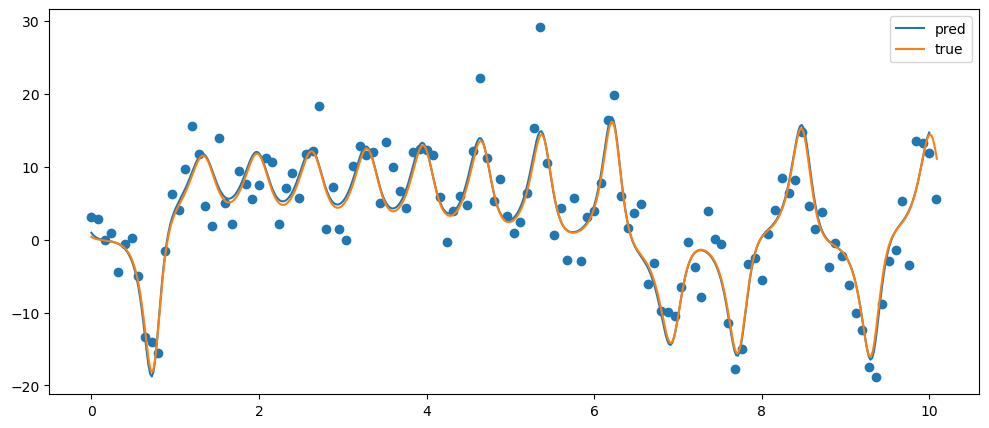

In [ ]:
tgrid = jnp.linspace(0,10,500)
xpred = model.predict_state(tgrid)
for index in range(3):
    plt.figure(figsize=(12,5))
    plt.plot(tgrid,xpred[:,index],label = 'pred')
    plt.plot(expdata.t_true,expdata.x_true[:,index],label = 'true')
    plt.scatter(expdata.t_train,expdata.x_train[:,index])
    plt.legend()
    plt.show()